importing the modules required for neural network

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

libraries added to implement bayesian optimization

In [19]:
import warnings
from bayes_opt.constraint import ConstraintModel
from bayes_opt import BayesianOptimization, UtilityFunction, util
# from .target_space import TargetSpace
# from .event import Events, DEFAULT_EVENTS
# from .logger import _get_default_logger
# from .util import UtilityFunction, acq_max, ensure_rng
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import roc_auc_score

importing the dataset

In [20]:
df = pd.read_csv("ercot-dataset.csv", sep=',')
# to change the float to two decimal places following code is used
pd.set_option('display.float_format', lambda x: '%.2f' % x)
#df = df.iloc[:80000]
print(df)

                   Date  DryBulb  DewPnt  WetBulb  Humidity  ElecPrice  Day  \
0         1/1/2006 0:30    23.90   21.65    22.40     87.50      19.67    1   
1         1/1/2006 1:00    23.90   21.70    22.40     88.00      18.56    1   
2         1/1/2006 1:30    23.80   21.65    22.35     88.00      19.09    1   
3         1/1/2006 2:00    23.70   21.60    22.30     88.00      17.40    1   
4         1/1/2006 2:30    23.70   21.60    22.30     88.00      17.00    1   
...                 ...      ...     ...      ...       ...        ...  ...   
87643  31/12/2010 22:00    22.60   19.10    20.40     81.00      23.86   31   
87644  31/12/2010 22:30    22.45   19.05    20.30     81.50      26.49   31   
87645  31/12/2010 23:00    22.30   19.00    20.20     82.00      25.18   31   
87646  31/12/2010 23:30    22.05   19.05    20.15     83.50      26.19   31   
87647     1/1/2011 0:00    21.80   19.10    20.10     85.00      24.62    1   

       Month  Year  Minutes  SYSLoad  
0          1

In [21]:
# prints the high level information about the data
'''df.info()'''

'df.info()'

In [22]:
# gives additional statistical information
'''df.describe()'''

'df.describe()'

In [23]:
# to check the total missing data on each features
# zero indicates there is no missing data values
df.isnull().sum()
#df1 = df.drop(['Date','Month','Year', 'Day','Minutes'], axis=1)
df1 = df.drop(['Date','Year'], axis=1)

In [24]:
# df1.corr()
# # to see the correlation between features
# # this helps to see how one parameters has effects on others
# # lets see the plot of correlation data
# sns.heatmap(df1.corr(), annot= True)
# plt.rcParams["figure.figsize"]=(15,10)
# plt.title('Correlation Matrix', fontsize=16)
# plt.show()

In [25]:
# this will select all the rows and columns except the last one from df and assign to x variable
# df1 does not contain the date in the first column in string format
x = df1.iloc[:,:-1].values
#x = df1.iloc[:,1].values
# quality is taken target variable and it in last column and is assigned to y variable
y = df1.iloc[:,-1].values
# encoding the categorical data using onehotencoder this is for classification tasks
'''ct = ColumnTransformer(transformers = [('encoder', OneHotEncoder(), [3])], remainder = 'passthrough')
x = ct.fit_transform(x)
x = x.toarray() # converts encoded data to dense array (optional) would show error without this'''

"ct = ColumnTransformer(transformers = [('encoder', OneHotEncoder(), [3])], remainder = 'passthrough')\nx = ct.fit_transform(x)\nx = x.toarray() # converts encoded data to dense array (optional) would show error without this"

Splitting the dataset into the training and test set

In [26]:
from sklearn.model_selection import train_test_split
# we will split the data into training and testing data using following code
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=0)
# print(f'Standard deviation of test data: {x_test.std()}')
# print(f'mean of test data: {x_test.mean()}')
# print(f'Standard deviation of train data: {x_train.std()}')
# print(f'mean deviation of train data: {x_train.mean()}')

feature standardization and conversion to tensor

In [27]:
# Feature Scaling (not necessary for neural networks, but can be applied)
sc_x = StandardScaler()
x_train = sc_x.fit_transform(x_train)
x_test = sc_x.transform(x_test)

# print(f'Standard deviation of test data: {x_test.std()}')
# print(f'mean of test data: {x_test.mean()}')
# print(f'Standard deviation of train data: {x_train.std()}')
# print(f'mean of train data: {x_train.mean()}')
# Convert data to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1,1)

x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1,1)

# Create a PyTorch dataset and DataLoader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
len(x_train)
#len(test_loader)

70118

Define the black box function to optimize

In [28]:
# # Import packages
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import cross_val_score
# from math import floor
# from sklearn.metrics import make_scorer, accuracy_score
# from bayes_opt import BayesianOptimization
# from sklearn.model_selection import StratifiedKFold
# import warnings
# warnings.filterwarnings('ignore')
# pd.set_option("display.max_columns", None)

In [29]:
# import tensorflow.keras.initializers
# import tensorflow.keras
# from tensorflow.keras.models import StratifiedKFold
# from keras.models import Sequential
# from keras.layers import Dense, BatchNormalization, Dropout
# from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
# from keras.callbacks import EarlyStopping, ModelCheckpoint
# from keras.wrappers.scikit_learn import KerasClassifier
# from keras.layers import LeakyReLU
# LeakyReLU = LeakyReLU(alpha=0.1)

In [30]:
# Make scorer accuracy
# score_acc = make_scorer(accuracy_score)

In [31]:
# # Creating a function
# def nn_cl_bo(neurons, activation, optimizer, learning_rate,  batch_size, epochs ):
#     optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','SGD']
#     optimizerD= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
#                  'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
#                  'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
#                  'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
#     activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
#                    'elu', 'exponential', LeakyReLU,'relu']
#     neurons = round(neurons)
#     activation = activationL[round(activation)]
#     batch_size = round(batch_size)
#     epochs = round(epochs)
#     def nn_cl_fun():
#         opt = Adam(lr = learning_rate)
#         nn = Sequential()
#         nn.add(Dense(neurons, input_dim=10, activation=activation))
#         nn.add(Dense(neurons, activation=activation))
#         nn.add(Dense(1, activation='sigmoid'))
#         nn.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
#         return nn
#     es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20)
#     nn = KerasClassifier(build_fn=nn_cl_fun, epochs=epochs, batch_size=batch_size,
#                          verbose=0)
#     kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
#     score = cross_val_score(nn, x_train, y_train, scoring=score_acc, cv=kfold, fit_params={'callbacks':[es]}).mean()
#     return score

The following code will set the range of hyperparameters and run the Bayesian Optimization

In [32]:
# # paramaters value range definition
# params_nn ={
#     'neurons': (10, 100),
#     'activation':(0, 9),
#     'optimizer':(0,7),
#     'learning_rate':(0.01, 1),
#     'batch_size':(200, 1000),
#     'epochs':(20, 100)
# }
# # execute Bayesian Optimization for the optimal hyperparameter values
# nn_bo = BayesianOptimization(nn_cl_bo, params_nn, random_state=111)
# nn_bo.maximize(init_points=25, n_iter=4)

In [33]:
# def balck_box_function(C):
#     # C: SVC hyper parameter to optimize for.
#     model = SVC(C = C)
#     model.fit(X_train_scaled, y_train)
#     y_score = model.decision_function(X_test_scaled)
#     f = roc_auc_score(y_test, y_score)
#     return f
# # Set range of C to optimize for.
# # bayes_opt requires this to be a dictionary.
# pbounds = {"C": [0.1, 10]}
# # Create a BayesianOptimization optimizer,
# # and optimize the given black_box_function.
# optimizer = BayesianOptimization(f = black_box_function, pbounds = pbounds, verbose = 2, random_state = 4)
# optimizer.maximize(init_points = 5, n_iter = 10)
# print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))

Deep Neural Network Model (3 hidden layers), forward pass and back propagation

In [34]:
from bayes_opt import BayesianOptimization
# Define the function to optimize
def train_model(lr, hidden_size1, hidden_size2, hidden_size3, num_epochs):
    # Define the neural network model
    class NeuralNetwork(nn.Module):
        def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3):
            super(NeuralNetwork, self).__init__()
            self.fc1 = nn.Linear(input_size, hidden_size1)   # using linear activation function at the input
            #self.relu = nn.ReLU()   # activation function for hidden layer, Relu
            self.sigmoid = nn.Sigmoid()   # activation function for hidden layer, sigmoid
            self.fc2 = nn.Linear(hidden_size1, hidden_size2)   # input layer to hidden layer
            self.fc3 = nn.Linear(hidden_size2, hidden_size3)
            self.fc4 = nn.Linear(hidden_size3, 1)
            # self.fc4 = nn.Linear(32, 16)
            # self.fc5 = nn.Linear(16, 1) # hidden to output layer

        def forward(self, X):
            X = self.fc1(X) #input layer
            X = self.sigmoid(X)
            X = self.fc2(X) # hidden layer
            X = self.sigmoid(X)
            X = self.fc3(X) # hidden layer
            #X = self.sigmoid(X)
            X = self.fc4(X) # hidden layer
            # X = self.fc5(X) # output layer
            return X
    
    # Instantiate the model and define the loss function and optimizer
    input_size = x_train.shape[1]
    model = NeuralNetwork(input_size, int(hidden_size1), int(hidden_size2),int(hidden_size3))
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Train the model
    #num_epochs = 20

    train_losses = []
    val_losses = []
    test = 0
    for epoch in range(int(num_epochs)):
        model.train()
        for inputs, labels in train_loader:
            total_loss = 0.0
            optimizer.zero_grad()
            outputs = model(inputs)
            #print(f'test output {len(outputs)}')
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            # print(test)
            # test += 1
            #print(f'test total loss {temp.shape}')
            #print(f'Total loss Test {total_loss}')

        # Validation loss/ this is loss for test
        model.eval()
        with torch.no_grad():
            for inputs, labels in test_loader:
                val_loss = 0.0
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                #print(np.array(val_loss).astype(int))
                #print(f'outputs Test {outputs}, labels {labels} ')

        avg_train_loss = total_loss / len(x_train)
        avg_val_loss = val_loss / len(x_test)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

    #print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}')

    # Evaluate the model on the test set
    model.eval()
    with torch.no_grad():
        y_pred_tensor = model(x_test_tensor)
        y_test_np = y_test_tensor.numpy()
        y_pred = y_pred_tensor.numpy()
        mse = mean_squared_error(y_test_np, y_pred)
    return -mse

# Define the search space for hyperparameters
pbounds = {'lr': (1e-5, 1e-1), 'hidden_size1': (8, 256), 'hidden_size2': (8, 128), 'hidden_size3': (8, 128), 'num_epochs':(10,100)}

# Initialize BayesianOptimization
optimizer = BayesianOptimization(
    f=train_model,
    pbounds=pbounds,
    random_state=42,
)

# Perform optimization
optimizer.maximize(init_points=5, n_iter=200)

# Get the best hyperparameters
best_params = optimizer.max['params']
print("Best Hyperparameters:", best_params)

# Train the model with the best hyperparameters
best_lr = best_params['lr']
best_hidden_size1 = best_params['hidden_size1']
best_hidden_size2 = best_params['hidden_size2']
best_hidden_size3 = best_params['hidden_size3']
best_num_epochs = best_params['num_epochs']

best_mse = train_model(best_lr, best_hidden_size1, best_hidden_size2, best_hidden_size3, best_num_epochs)
print("Best Mean Squared Error:", -best_mse)  # Convert back to positive MSE
#r2_score(y_test, y_pred)

# # Convert predictions back to NumPy arrays
# y_pred = y_pred_tensor.numpy()
# y_test_np = y_test_tensor.numpy()

# # Evaluate the Model Performance
# mse = mean_squared_error(y_test_np, y_pred)
# mae = mean_absolute_error(y_test_np, y_pred)
# r2 = r2_score(y_test_np, y_pred)
# #print(f'y_test_np: {y_test_np}, y_pred: {y_pred}')
# #print(f'length y_test_np: {len(y_test_np)}')

# print(f'Mean Squared Error: {mse}')
# print(f'Mean Absolute Error: {mae}')
# print(f'R-squared: {r2}')

# # Plotting the learning curve
# plt.plot(train_losses, label='Training Loss')
# plt.plot(val_losses, label='Validation Loss')
# plt.legend()
# plt.title('Learning Curve')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.show()

# # Plotting the results (optional)
# plt.scatter(y_test, y_pred, color='blue')
# plt.title('Neural Network')
# plt.xlabel('Actual values')
# plt.ylabel('Predicted values')
# plt.show()

|   iter    |  target   | hidden... | hidden... | hidden... |    lr     | num_ep... |
-------------------------------------------------------------------------------------
| 1         | -3.095e+0 | 100.9     | 122.1     | 95.84     | 0.05987   | 24.04     |
| 2         | -2.564e+0 | 46.69     | 14.97     | 111.9     | 0.06012   | 73.73     |
| 3         | -2.484e+0 | 13.1      | 124.4     | 107.9     | 0.02124   | 26.36     |
| 4         | -2.582e+0 | 53.48     | 44.51     | 70.97     | 0.0432    | 36.21     |
| 5         | -2.648e+0 | 159.7     | 24.74     | 43.06     | 0.03664   | 51.05     |
| 6         | -2.72e+05 | 22.02     | 123.9     | 108.5     | 0.07934   | 37.44     |
| 7         | -2.012e+0 | 232.8     | 20.64     | 25.67     | 0.09253   | 79.36     |
| 8         | -2.449e+0 | 51.58     | 50.57     | 70.76     | 0.04401   | 34.9      |
| 9         | -8.025e+0 | 136.2     | 8.0       | 128.0     | 1e-05     | 10.0      |
| 10        | -2.634e+0 | 163.6     | 24.35     | 46.3

In [35]:
# y_test_np = y_test_tensor.numpy()
# y_pred = y_pred_tensor.numpy()
# # plot of test and predicted value
# plt.plot(y_test_np[100:200], label='Test Value')
# plt.plot(y_pred[100:200],linestyle='--', linewidth = 1.2, label='Predicted Value')
# plt.legend()
# plt.title('Test Vs Predicted value')
# plt.xlabel('Actual/Predicted values')
# plt.ylabel('values')
# plt.show()

Mean Squared Error: 185456.375
Mean Absolute Error: 330.4382629394531
R-squared: 0.9078037686961216


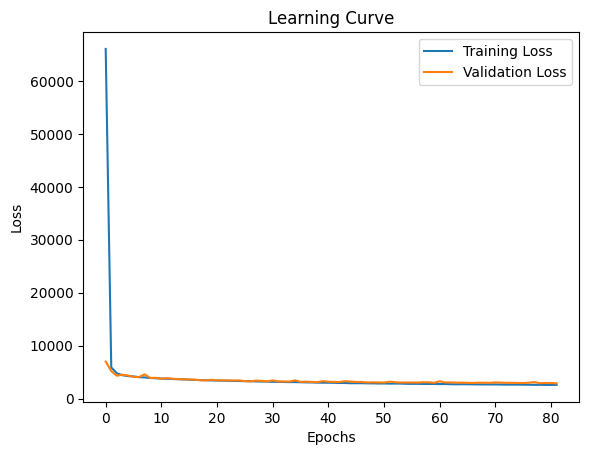

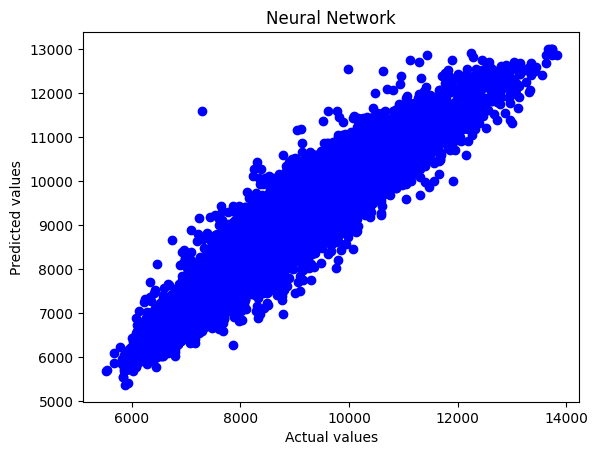

In [37]:
best_lr, best_hidden_size1, best_hidden_size2, best_hidden_size3, best_num_epochs
hidden_size1 = best_hidden_size1
hidden_size2 = best_hidden_size2
hidden_size3 = best_hidden_size3
num_epochs = best_num_epochs

# Define the neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)   # using linear activation function at the input
        #self.relu = nn.ReLU()   # activation function for hidden layer, Relu
        self.sigmoid = nn.Sigmoid()   # activation function for hidden layer, sigmoid
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)   # input layer to hidden layer
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, 1)
        # self.fc5 = nn.Linear(16, 1) # hidden to output layer

    def forward(self, X):
        X = self.fc1(X) #input layer
        X = self.sigmoid(X)
        X = self.fc2(X) # hidden layer
        X = self.sigmoid(X)
        X = self.fc3(X) # hidden layer
        #X = self.sigmoid(X)
        X = self.fc4(X) # hidden layer
        # X = self.fc5(X) # output layer
        return X
    
# Instantiate the model and define the loss function and optimizer
hidden_size1 = 132
hidden_size2 = 86
hidden_size3 = 39
input_size = x_train.shape[1]
model = NeuralNetwork(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0166)

# Train the model
# num_epochs = 82

train_losses = []
val_losses = []
test = 0
for epoch in range(int(num_epochs)):
    model.train()
    total_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        #print(f'test output {len(outputs)}')
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        # print(test)
        # test += 1
        #print(f'test total loss {temp.shape}')
        #print(f'Total loss Test {total_loss}')

    # Validation loss/ this is loss for test
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for inputs, labels in test_loader:
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            #print(np.array(val_loss).astype(int))
            #print(f'outputs Test {outputs}, labels {labels} ')

    avg_train_loss = total_loss / len(x_train)
    avg_val_loss = val_loss / len(x_test)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    #print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}')

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    y_pred_tensor = model(x_test_tensor)

# Convert predictions back to NumPy arrays
y_pred = y_pred_tensor.numpy()
y_test_np = y_test_tensor.numpy()

# Evaluate the Model Performance
mse = mean_squared_error(y_test_np, y_pred)
mae = mean_absolute_error(y_test_np, y_pred)
r2 = r2_score(y_test_np, y_pred)
#print(f'y_test_np: {y_test_np}, y_pred: {y_pred}')
#print(f'length y_test_np: {len(y_test_np)}')

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

# Plotting the learning curve
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Plotting the results (optional)
plt.scatter(y_test, y_pred, color='blue')
plt.title('Neural Network')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()

In [ ]:
# plot of test and predicted value
plt.plot(y_test_np[100:200], label='Test Value')
plt.plot(y_pred[100:200],linestyle='--', linewidth = 1.2, label='Predicted Value')
plt.legend()
plt.title('Test Vs Predicted value')
plt.xlabel('Actual/Predicted values')
plt.ylabel('values')
plt.show()

visualization of the neural network results graphically

Evaluating the model performance